<a href="https://colab.research.google.com/github/YASHBATTUL02/IIT_GANDHINAGAR_INTERNSHIP_YASH_BATTUL/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implement two hidden layers neural network classifier from scratch in JAX **

Import packages
We need JAX,
\\JAX optimizers, the JAX version of Numpy and matplotlib for plottinG

In [ ]:
%matplotlib inline
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


To reduce the dependencies on external tools to fetch the MNIST dataset here i directly used from Yann Lecun's website.....( USED AS REFERENCE ) IT IS EASY TO DOWNLOAD DATA 


In [ ]:
def fetch_mnist(directory:str="mnist_data", redownload:bool=False):
    
    import os
    directory = os.path.abspath(os.path.expanduser(directory))
    os.makedirs(directory, exist_ok=True)
    
    if not redownload and os.path.exists(f'{directory}/train.npy') and os.path.exists(f'{directory}/test.npy'):
        return jnp.load(f'{directory}/train.npy'), jnp.load(f'{directory}/test.npy')
        
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    from urllib.request import urlretrieve
    if redownload or not os.path.exists(f'{directory}/train_images.gz'):
        print("downloading train images from 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', f'{directory}/train_images.gz')
    if redownload or not os.path.exists(f'{directory}/train_labels.gz'):
        print("downloading train labels from 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', f'{directory}/train_labels.gz')
    if redownload or not os.path.exists(f'{directory}/test_images.gz'):
        print("downloading test images from 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', f'{directory}/test_images.gz')
    if redownload or not os.path.exists(f'{directory}/test_labels.gz'):
        print("downloading test labels from 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', f'{directory}/test_labels.gz')

   
   
   
   
    # empty arrays to fill & use of standard numpy
   
    from numpy import empty, uint8
    train = empty((80, 785), dtype=uint8)
    test = empty((20, 785), dtype=uint8)
    
    print('converting .gz data to .npy')

    import gzip                                                                #to compress the data 
    for type, npdata in [('train', train), ('test', test)]:
        # open the files
        with gzip.open(f'{directory}/%s_images.gz'%type, 'rb') as data,\
             gzip.open(f'{directory}/%s_labels.gz'%type, 'rb') as labels:

            # skip the first bytes with metadata of the ubyte file:
            data.read(16)
            labels.read(8)

            # read each byte of the gzip file and save it as a uint8 number
            # in the numpy array.
            for i in range(npdata.shape[0]):
                npdata[i,0] = ord(labels.read(1))
                for j in range(784): # append the data after the label
                    npdata[i, j+1] = ord(data.read(1))
                    
    train = jax.device_put(train)
    test = jax.device_put(test)

    # save numpy arrays
    jnp.save(f'{directory}/train.npy', train)
    jnp.save(f'{directory}/test.npy', test)
    
    print('finished conversion.')

    return train, test

The image values are specified by integers between 0 and 255. 
We convert these pixel values to floats between 0 and 1. 
Moreover, we split the data in a training set of  images, a validation set of 80 images and a test set of 20 images

In [ ]:
test_size, valid_size = 80,20
train_data, test_data = fetch_mnist()
data = jnp.vstack([train_data, test_data])
train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]
train_size = train_data.shape[0]

def get_values_labels(data):
    labels = jnp.array(data[:,0], dtype=jnp.int32)
    values = jnp.array(data[:,1:], dtype=jnp.float32)/255.0
    return values, labels

train_values, train_labels = get_values_labels(train_data)
valid_values, valid_labels = get_values_labels(valid_data)
test_values, test_labels = get_values_labels(test_data)
num_pixels = train_values.shape[-1]
num_labels = int(train_labels.max())+1

print(f'train data shape:\t{train_values.shape}')
print(f'train labels shape:\t{train_labels.shape}')

train data shape:	(69900, 784)
train labels shape:	(69900,)


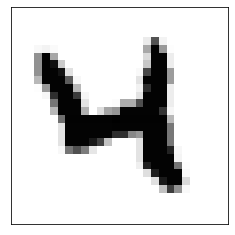

In [ ]:
def show_digit(digit_array):
    plt.imshow(digit_array.reshape(28, 28), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[20])

Random number generator

In [ ]:
prng = jax.random.PRNGKey(32)

In [ ]:
prng, key = jax.random.split(prng, 2)
jax.random.normal(key, (3,3))

DeviceArray([[-0.04187232,  1.7136184 ,  0.8067488 ],
             [-0.30050832, -0.55049413, -0.14928241],
             [-0.9825231 , -0.12566416,  0.7751663 ]], dtype=float32)

Model a simple three layer fully connected neural network.

In [ ]:
prng, w1key, b1key, w2key, b2key, w3key, b3key = jax.random.split(prng, 7)
num_hidden1 = 200
num_hidden2 = 150
params = dict(
    w1 = 1e-2*jax.random.normal(w1key, (num_pixels, num_hidden1)),
    b1 = 1e-2*jax.random.normal(b1key, (1, num_hidden1)),
    w2 = 1e-2*jax.random.normal(w2key, (num_hidden1, num_hidden2)),
    b2 = 1e-2*jax.random.normal(b2key, (1, num_hidden2)),
    w3 = 1e-2*jax.random.normal(w3key, (num_hidden2, num_labels)),
    b3 = 1e-2*jax.random.normal(b3key, (1, num_labels)),
)

In [ ]:
@jax.jit
def forward(params, x):
    x = jax.nn.relu(x@params["w1"] + params["b1"])
    x = jax.nn.relu(x@params["w2"] + params["b2"])      
    x = x@params["w3"] + params["b3"]
    return x

train data

In [ ]:
@jax.jit
def train_step(step, optim_state, x, y):
    params = optim_params(optim_state)
    loss, grads = jax.value_and_grad(lossforward)(params, x, y)
    optim_state = optim_update(step, grads, optim_state)
    return loss, optim_state
    

In [ ]:
history = []
batch_size = 100
num_steps = 500
for step in range(num_steps):
    if step%200 == 0 or step == num_steps - 1:
        valid_logits = forward(optim_params(optim_state), valid_values)
        valid_loss = xeloss(valid_logits, valid_labels)
        valid_accuracy = accuracy(valid_logits, valid_labels)
        history.append((step, valid_loss, valid_accuracy))
        print(f"Step {step:5.0f}\t Valid. Acc. = {valid_accuracy:5.2f}")
    prng, key = jax.random.split(prng)
    idxs = jax.random.randint(key, (batch_size,), 0, train_size)
    x = train_values[idxs]
    y = train_labels[idxs]
    loss, optim_state = train_step(step, optim_state, x, y)

Step     0	 Valid. Acc. = 100.00
Step   200	 Valid. Acc. = 100.00
Step   400	 Valid. Acc. = 100.00
Step   499	 Valid. Acc. = 100.00


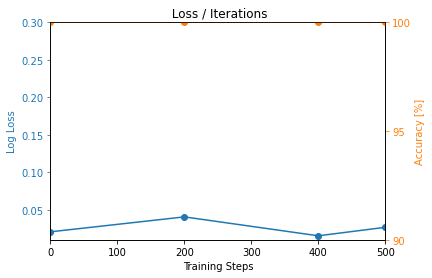

In [ ]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(90,100)
plt.yticks([90,95,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
m = 1.1*max(loss)
plt.ylim(0.01, 0.3)

plt.xlim(0, (max(steps)+100)//100*100)
plt.xlabel('Training Steps')
plt.title(' Loss / Iterations')
plt.show()

Test

In [ ]:
params = optim_params(optim_state)
test_logits = forward(params, test_values)
test_accuracy = accuracy(test_logits, test_labels)
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 98.75
